In [2]:
import struct
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
def decode_labels(file):

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_items = struct.unpack_from(">II", binary_data, 0)
    labels = struct.unpack_from("B" * num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int)


def decode_images(file):

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_images, rows, cols = struct.unpack_from(">IIII", binary_data, 0)
    images = struct.unpack_from("B" * (num_images * cols * rows), binary_data, 16)
    return np.array(images).reshape(-1, rows * cols)

In [15]:
def relu(x):
    return x * (x > 0)

def derelu(x):
    return (x > 0).astype(np.float32)

def sigmoid(x):
    output = 1 / (1 + np.exp(-x))
    return np.clip(output, a_min=1e-5, a_max=1-1e-5)

def desigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def cross_entropy(target, predict):
    return np.sum(target * np.log(predict) + (1 - target) * np.log(1 - predict))

def softmax(predict):
    exp_predict = np.exp(predict)
    total = np.sum(exp_predict, axis=1, keepdims=True)
    return exp_predict / total

def one_hot(t, num_classes):
    
    rows = t.shape[0]
    output = np.zeros((rows, num_classes))
    
    for row in range(rows):
        label = t[row, 0]
        output[row, label] = 1
    return output

def norm_image(image):
    return (image / 255 - 0.5).astype(np.float32)

In [5]:
train_images = decode_images("_notes_task/stage_1/data/mnist/train-images-idx3-ubyte")
train_labels = decode_labels("_notes_task/stage_1/data/mnist/train-labels-idx1-ubyte")
test_images = decode_images("_notes_task/stage_1/data/mnist/t10k-images-idx3-ubyte")
test_labels = decode_labels("_notes_task/stage_1/data/mnist/t10k-labels-idx1-ubyte")

In [17]:
train_images.shape, train_labels.shape

((60000, 784), (60000, 1))

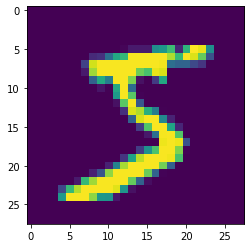

In [18]:
plt.imshow(train_images[0].reshape(28, 28))

In [19]:
class Linear:
    def __init__(self, num_input, num_output):
        self.weight = np.random.normal(0, 1, size=(num_input, num_output))
        self.bias   = np.zeros((num_output,))
    
    def forward(self, x):
        # save for backward
        self.x = x
        return x @ self.weight + self.bias
    
    def backward(self, g):
        self.dweight = self.x.T @ g
        self.dbias   = np.sum(g, axis=0)
        return g @ self.weight.T
    
class Sigmoid:
    def forward(self, x):
        # save for backward
        self.x = x
        return sigmoid(x)
    
    def backward(self, g):
        return g * sigmoid(self.x) * (1 - sigmoid(self.x))
    
    
# 包含了softmax操作和loss计算，返回的是loss
class SoftmaxCrossEntropyLoss:
    def forward(self, x, target):
        self.batch_size  = len(x)
        self.probability = softmax(x)
        self.target      = target
        return -np.sum(target * np.log(self.probability)) / self.batch_size
    
    def backward(self, g=1):
        g = g * self.probability
        return (g - self.target) / self.batch_size
    
    
class Network:
    def __init__(self, num_feature, num_hidden, num_classes):
        self.layers = [
            Linear(num_feature, num_hidden),
            Sigmoid(),
            Linear(num_hidden, num_classes),
        ]
        self.loss = SoftmaxCrossEntropyLoss()
        
    def inference(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
        
    def forward(self, x, target):
        return self.loss.forward(self.inference(x), target)
    
    def backward(self):
        g = self.loss.backward()
        for layer in self.layers[::-1]:
            g = layer.backward(g)
            
            
class OptimizerSGD:
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
        
    def set_lr(self, lr):
        self.lr = lr
        
    def step(self):
        for layer in self.model.layers:
            if isinstance(layer, Linear):
                layer.weight -= self.lr * layer.dweight
                layer.bias   -= self.lr * layer.dbias
                

def save_model(file, model):
    with open(file, "wb") as f:
        f.write(pickle.dumps(model))
        
def load_model(file):
    with open(file, "rb") as f:
        return pickle.loads(f.read())

In [20]:
batch_size  = 256
num_hidden  = 256
num_classes = 10
num_train_images = train_images.shape[0]
num_feature      = train_images.shape[1]

batch_per_epoch = math.ceil(num_train_images / batch_size)
train_epochs    = 10

lr_schedule = {
    0: 1e-1,
    50: 1e-2,
    80: 1e-3,
    90: 1e-4
}
network = Network(num_feature, num_hidden, num_classes)
optim   = OptimizerSGD(network, 0.1)

all_train_image_indexs = list(range(num_train_images))
for epoch_index in range(train_epochs):
    
    if epoch_index in lr_schedule:
        optim.set_lr(lr_schedule[epoch_index])
    
    # 打乱索引
    random.shuffle(all_train_image_indexs)
    for batch_index in range(batch_per_epoch):
        niter       = epoch_index * batch_per_epoch + batch_index
        index_begin = batch_index * batch_size
        index_end   = min(index_begin + batch_size, num_train_images)
        
        # 选择一个批次的索引
        select_indexs = all_train_image_indexs[index_begin:index_end]
        
        train_batch_images = norm_image(train_images[select_indexs])
        train_batch_labels = train_labels[select_indexs]
        train_batch_target = one_hot(train_batch_labels, num_classes=num_classes)
        loss = network.forward(train_batch_images, train_batch_target)
        network.backward()
        optim.step()
    
        if niter % 100 == 0:
            epoch_index_float = epoch_index + batch_index / batch_per_epoch
            predict        = network.inference(norm_image(test_images))
            predict_labels = predict.argmax(axis=1)
            correct        = predict_labels == test_labels[:, 0]
            accuracy       = correct.sum() / len(test_images)
            
            # save_model("last.pt", network)
            print(f"Iter: {niter}, Epoch: {epoch_index_float:.2f}/{train_epochs}, LR: {optim.lr:.6f}, Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")

Iter: 0, Epoch: 0.00/10, LR: 0.100000, Loss: 14.069, Test Accuracy: 0.101
Iter: 100, Epoch: 0.43/10, LR: 0.100000, Loss: 2.312, Test Accuracy: 0.540
Iter: 200, Epoch: 0.85/10, LR: 0.100000, Loss: 1.505, Test Accuracy: 0.653
Iter: 300, Epoch: 1.28/10, LR: 0.100000, Loss: 1.082, Test Accuracy: 0.707
Iter: 400, Epoch: 1.70/10, LR: 0.100000, Loss: 0.939, Test Accuracy: 0.740
Iter: 500, Epoch: 2.13/10, LR: 0.100000, Loss: 1.045, Test Accuracy: 0.761
Iter: 600, Epoch: 2.55/10, LR: 0.100000, Loss: 0.768, Test Accuracy: 0.778
Iter: 700, Epoch: 2.98/10, LR: 0.100000, Loss: 0.622, Test Accuracy: 0.793
Iter: 800, Epoch: 3.40/10, LR: 0.100000, Loss: 0.802, Test Accuracy: 0.802
Iter: 900, Epoch: 3.83/10, LR: 0.100000, Loss: 0.727, Test Accuracy: 0.811
Iter: 1000, Epoch: 4.26/10, LR: 0.100000, Loss: 0.696, Test Accuracy: 0.817
Iter: 1100, Epoch: 4.68/10, LR: 0.100000, Loss: 0.680, Test Accuracy: 0.824
Iter: 1200, Epoch: 5.11/10, LR: 0.100000, Loss: 0.789, Test Accuracy: 0.830
Iter: 1300, Epoch: 5.53

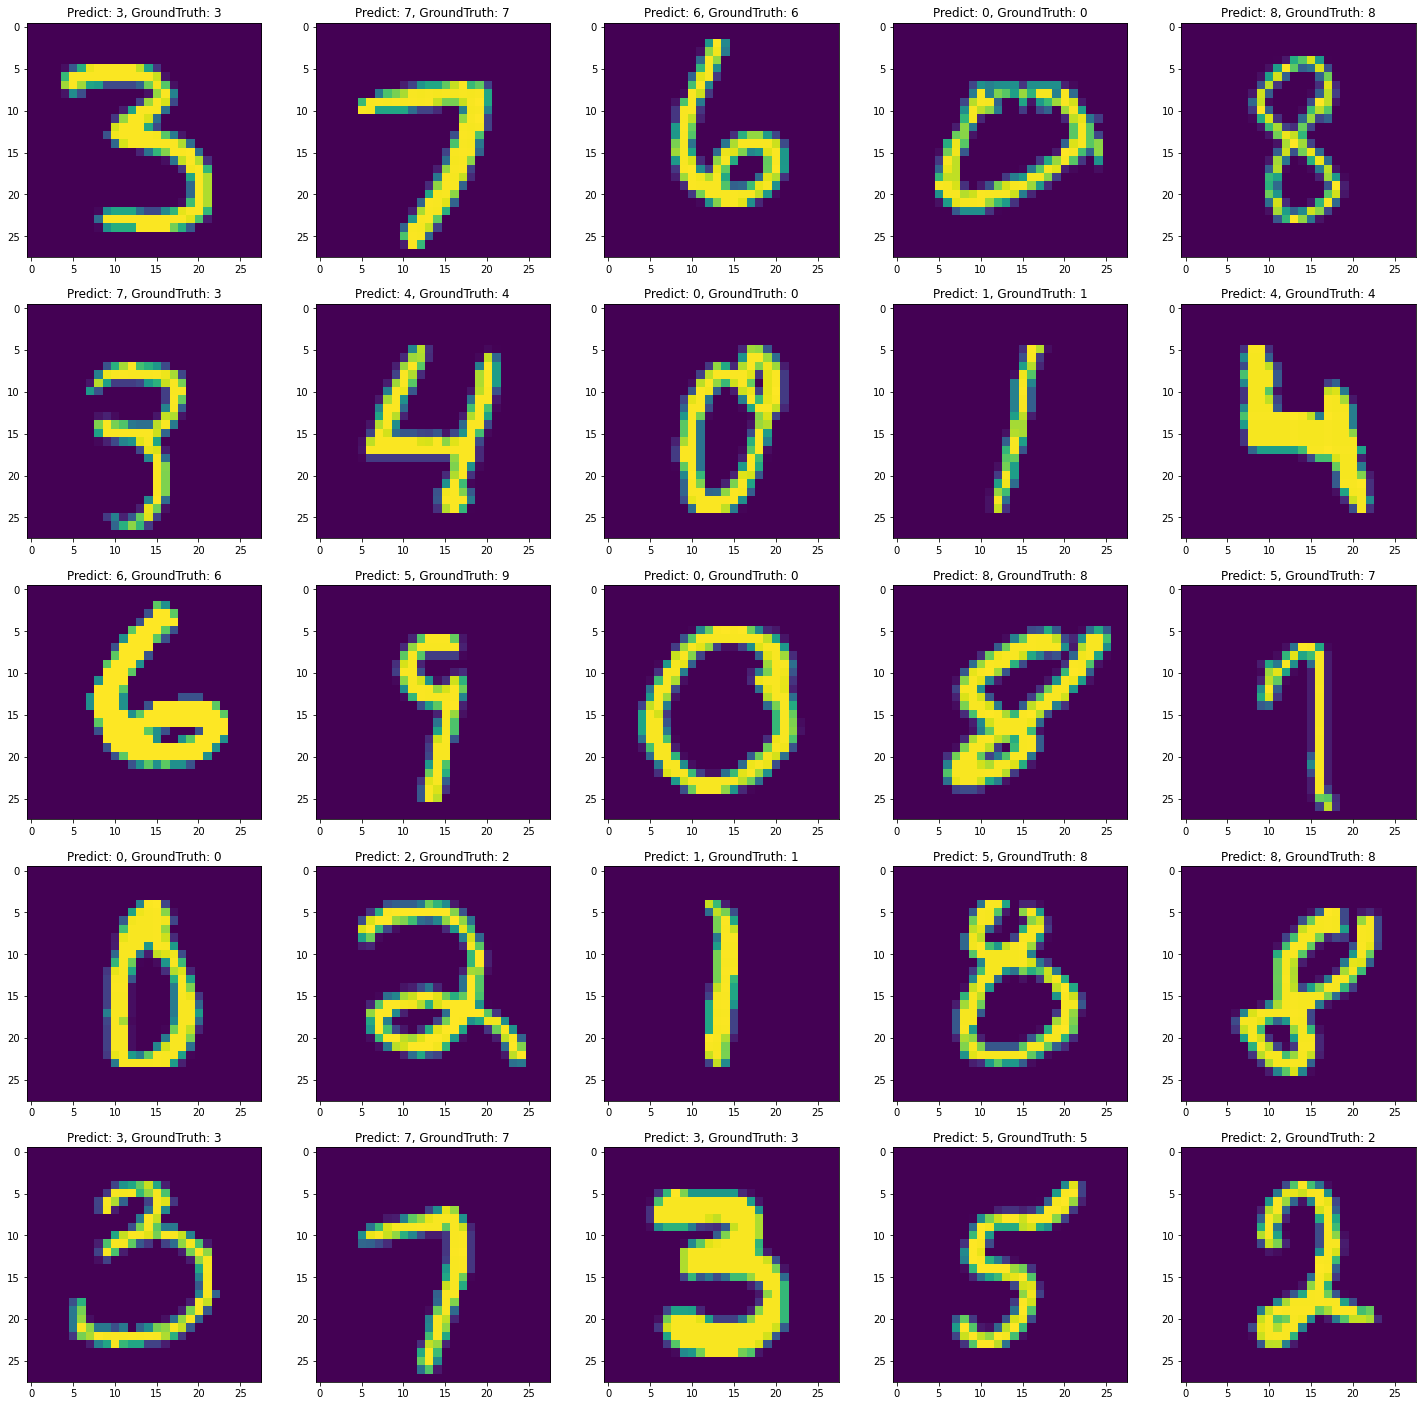

In [22]:
# network = load_model("last.pt")
show_rows = 5
show_cols = 5
select_count = show_rows * show_cols
select_index = list(range(len(test_images)))
random.shuffle(select_index)
select_index = select_index[:select_count]
select_images = test_images[select_index]
select_labels = test_labels[select_index]

predict        = network.inference(norm_image(select_images))
predict_labels = predict.argmax(axis=1)

plt.figure(figsize=(show_rows * 5, show_cols * 5))

for i in range(select_count):
    
    plt.subplot(show_rows, show_cols, i+1)
    
    predict_label      = predict_labels[i]
    ground_truth_label = select_labels[i, 0]
    image              = select_images[i].reshape(28, 28)

    plt.title(f"Predict: {predict_label}, GroundTruth: {ground_truth_label}")
    plt.imshow(image)